In [201]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [202]:
%load_ext autoreload
%autoreload 2

from pyDO3SE.plugins.carbon_allocation.calculations import *
from pyDO3SE.plugins.carbon_allocation.conversions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
df_in = pd.read_csv('examples/spanish_wheat/data/spanish_wheat_data.csv')

In [204]:
df = pd.read_csv('examples/spanish_wheat/output/Latest/pyDO3SE_output_4.11.0c.csv')
# df = df.iloc[2000:4500]
df.head()

,Unnamed: 0,dd,ts_c,par,lai,sai,dvi,photoperiod,PARsun,PARshade,...,rinc,V_cmax_25,J_max_25,f_LS,LAIsunfrac,component_LAI,V_cmax,J_max,R_d,R_dc
0,0,1,3.28,0.0,0.0,4.285714,-1.0,10.201689,0.0,0.0,...,2.786999,180.0,400.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0
1,1,1,3.54,0.0,0.0,4.285714,-1.0,10.201689,0.0,0.0,...,2.786999,180.0,400.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0
2,2,1,3.41,0.0,0.0,4.285714,-1.0,10.201689,0.0,0.0,...,2.786999,180.0,400.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0
3,3,1,3.09,0.0,0.0,4.285714,-1.0,10.201689,0.0,0.0,...,2.786999,180.0,400.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0
4,4,1,3.22,0.0,0.0,4.285714,-1.0,10.201689,0.0,0.0,...,2.898479,180.0,400.0,1.0,0.0,0.0,NaN,NaN,0.0,0.0


# Demo run

In [205]:
hrs = [hr for dd in range(365) for hr in range(24)]
dd_hourly = [dd for dd in range(365) for hr in range(24)]
dd_daily = [dd for dd in range(365)]

In [243]:
# To get a total annual accumulated NPP we need to get an average hourlt Ac value of...
annual_NPP_acc = 1.0 # kg..
average_hourly_NPP = annual_NPP_acc / (365*24)
print(f"average_hourly_NPP: {average_hourly_NPP}")
average_hourly_Ac = average_hourly_NPP/(0.012*0.75)
annual_Ac_acc = average_hourly_Ac * (365*24)
print(f"average_hourly_Ac:{average_hourly_Ac}, \nannual_Ac_acc: {annual_Ac_acc}")

average_hourly_NPP: 0.00011415525114155251
average_hourly_Ac:0.012683916793505832, 
annual_Ac_acc: 111.11111111111109


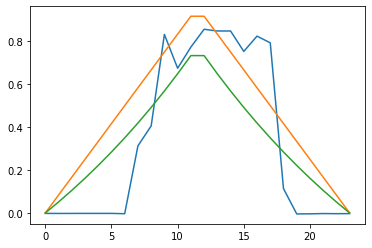

In [231]:

hourly_profile = np.array([-2.49E-04,-2.77E-04,-2.63E-04,-2.43E-04,-2.47E-04,-2.45E-04,-4.27E-04,3.91E-02,5.07E-02,1.04E-01,8.43E-02,9.66E-02,1.07E-01,1.06E-01,1.06E-01,9.41E-02,1.03E-01,9.91E-02,1.42E-02,-5.46E-04,-4.93E-04,-3.43E-04,-4.08E-04,-3.74E-04,
])*8
hourly_ratio = np.concatenate((np.arange(0,1,1/12), np.flip(np.arange(0,1,1/12))), axis=None)
hourly_ratio_b = np.concatenate((np.exp(np.arange(0,0.6,0.6/12))-1, np.flip(np.exp(np.arange(0,0.6,0.6/12))-1)), axis=None)
plt.plot(hourly_profile)
plt.plot(hourly_ratio)
plt.plot(hourly_ratio_b)

73.26610099199992


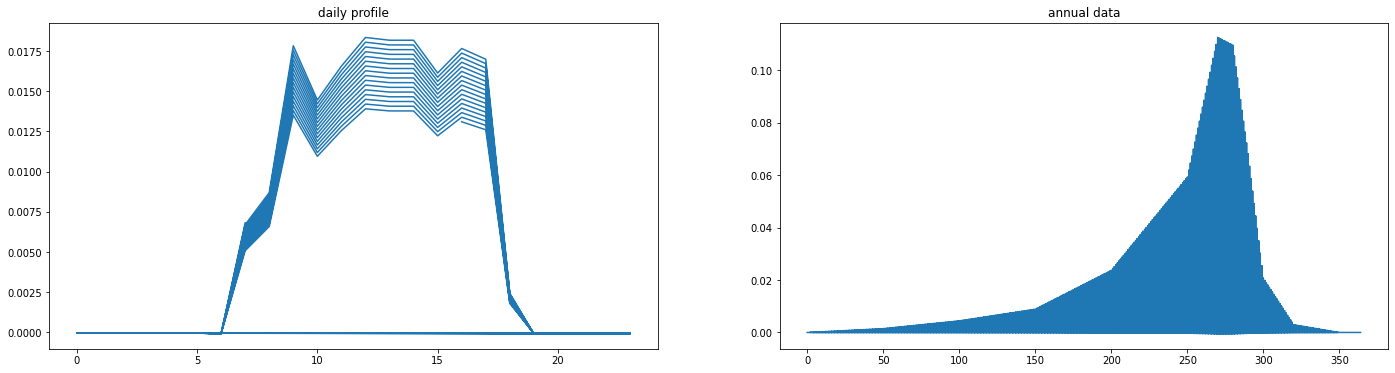

In [282]:
# Generate Anet data
# Taken from Winter Wheat Oklahoma graph
x = [0,50,100,150,200,250,270, 280, 290,300,320,350]
y= [0,0.5,1.5,3,8,20,38, 37, 23,7,1,0]

MULTIPLIER = 80

anet_daily_max = np.interp(dd_daily, x, y)
anet_hourly = [umol_c_to_kg_c(an*hm)*MULTIPLIER for an in anet_daily_max for hm in hourly_profile]
fig, axs = plt.subplots(ncols=2, figsize=(24,6))

axs[0].plot(hrs[4000: 4400], anet_hourly[4000:4400])
axs[0].set_title("daily profile")
axs[1].plot(dd_hourly, anet_hourly)
axs[1].set_title("annual data")

print(sum(anet_hourly))
# Assert that our accumulated anet meets requirements
# assert sum(anet_hourly) > annual_Ac_acc




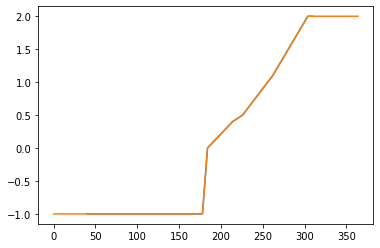

In [283]:
# Generate DVI data
a = -100
b = 0.6
x = b*np.array([a,129,130,140,190,210, 230, 270, 340,341,342,350]) - a
# x = [0,50,80,150,200,300,340, 350, 351,352, 353,354]
y= np.array([-1.001,-1.001,-0.99,0.0,0.4,0.5,0.7, 1.1, 2,2,2,2])
# y= [0.0,0.2,0.3,0.7, 1.1, 2,2,2,2, 2, 2, 2]
dvi_hourly = np.interp(dd_hourly, x, y)
plt.plot(x, y)
plt.plot(dd_hourly, dvi_hourly)

In [284]:
cparams = {
    "a_root": 18.5, # Param
    "a_stem": 16.0, # Param
    "a_leaf": 18.0, # Param
    "b_root": -20.0, # Param
    "b_stem": -15.0, # Param
    "b_leaf": -18.5, # Param
    "gamma": 27.3,
    "delta": -0.0507,
    "r_g": 0.25, # TODO: Check this value
    "R_dc": 0.32, # TODO: Check this value
    "pr_resv": 0.4,
    "k": 1.4,
}
cultivar = "wheat"

In [285]:
# State
ModelState = namedtuple('ModelState', [
    "c_root",
    "c_stem",
    "c_leaf",
    "c_harv",
    "c_resv",
    "net_prod_acc",
    "lai",
    "plant_height",
    "p_root",
    "p_leaf",
    "p_stem",
    "p_harv",
])
# Parameters

# Initial state
model_state = ModelState(
    c_root=0,
    c_stem=0,
    c_leaf=0,
    c_harv = 0,
    c_resv = 0,
    net_prod_acc=0,
    lai=0,
    plant_height=0,
    p_root=0,
    p_leaf=0,
    p_stem=0,
    p_harv=0,
)


In [286]:
logs = []
init_carbon = 8e-4
has_emerged = False
for dd in range(365):
    net_prod_acc = 0
    for hr in range(24):
        row_index = (dd*24) + hr
        DVI = dvi_hourly[row_index]
        An_canopy = anet_hourly[row_index] * model_state.lai
        net_prod_acc += calc_net_prod(
            An_canopy,
            model_state.c_root,
            model_state.c_stem,
            model_state.c_leaf,            
            0, #umol_c_to_kg_c(cparams["R_dc"]),
            cparams["r_g"],
        )
    # == End of day ==
    if has_emerged:
        net_prod_acc = max(0, net_prod_acc)
    else:
        net_prod_acc = init_carbon

    if DVI > 0.0:
        has_emerged = True
    
    (p_root, p_leaf, p_stem, p_harv)= calc_partition_coefficients(
        DVI if DVI > 0 else 0, # -1 -> 2
        cparams["a_root"],
        cparams["a_leaf"],
        cparams["a_stem"],
        cparams["b_root"],
        cparams["b_leaf"],
        cparams["b_stem"],
    )

    (
        c_root_diff,
        c_leaf_diff,
        c_stem_diff,
        c_harv_diff,
        c_resv_diff
    ) = calc_carbon_pool_change(
        net_prod_acc, # acumulated net productivity
        p_root,  # partition coefficient for root
        p_leaf,  # partition coefficient for leaf
        p_stem,  # partition coefficient for stem
        p_harv,  # partition coefficient for harv
        cparams["pr_resv"],
    )
    
    if DVI>0:
        c_root = max(0, model_state.c_root + c_root_diff)
        c_stem = max(0, model_state.c_stem + c_stem_diff)
        c_leaf = max(0, model_state.c_leaf + c_leaf_diff)
        c_harv = max(0, model_state.c_harv + c_harv_diff)
        c_resv = max(0, model_state.c_resv + c_resv_diff)
    elif DVI > -1:
        c_root = c_root_diff
        c_stem = c_stem_diff
        c_leaf = c_leaf_diff
        c_harv = c_harv_diff
        c_resv = c_resv_diff
    else: 
        c_root = 0
        c_stem = 0
        c_leaf = 0
        c_harv = 0
        c_resv = 0

    if p_stem < 0.01:
        c_harv = c_harv + 0.1 * c_resv
        c_resv = 0.9 * c_resv

    if DVI > 1.5:
        c_harv = c_harv + 0.05 * c_leaf
        c_leaf = 0.95 * c_leaf  
    
        
    lai = calc_LAI_from_DVI_and_carbon(
        DVI,
        c_leaf,
        gamma = cparams["gamma"], # Param
        delta = cparams["delta"], # Param
        f_c = 0.5, # Const
    )

    plant_height = get_plant_height_from_carbon(
        c_stem,
        lambdav = 0.4, # Param same for all cultivars in table 4
        k = cparams["k"], # Param
        f_c = 0.5, # Const
    )
    # ) if 2>DVI>0 else 0
   
    model_state = ModelState(
        c_root = c_root,
        c_stem = c_stem,
        c_leaf = c_leaf,
        c_harv = c_harv,
        c_resv = c_resv,
        net_prod_acc=net_prod_acc,
        lai=lai,
        plant_height=plant_height,
        p_root=p_root,
        p_leaf=p_leaf,
        p_stem=p_stem,
        p_harv=p_harv,
    )
    logs.append(model_state)

logs[-1]


ModelState(c_root=0.0257339042596387, c_stem=0.09709107167345021, c_leaf=0.0006772326793991622, c_harv=0.7915774372139864, c_resv=4.939158545492895e-06, net_prod_acc=0, lai=0.035646548153340944, plant_height=0.726794700350941, p_root=4.5990515265262127e-10, p_leaf=5.602791744686968e-09, p_stem=8.315280226228297e-07, p_harv=0.9999991624092804)

In [287]:
# Totals
# Calc crop yield per sqm
crop_yield = model_state.c_harv * 2  * 1.16 * 10
print(f"yield :{crop_yield}")

# Total NPP (Should be approx 1kg)
total_NPP = sum([o.net_prod_acc for o in logs])
print(f"total npp: {total_NPP} [kg C m^-2]")

yield :18.364596543364485
total npp: 1.0622845849850209 [kg C m^-2]


# Graph Output

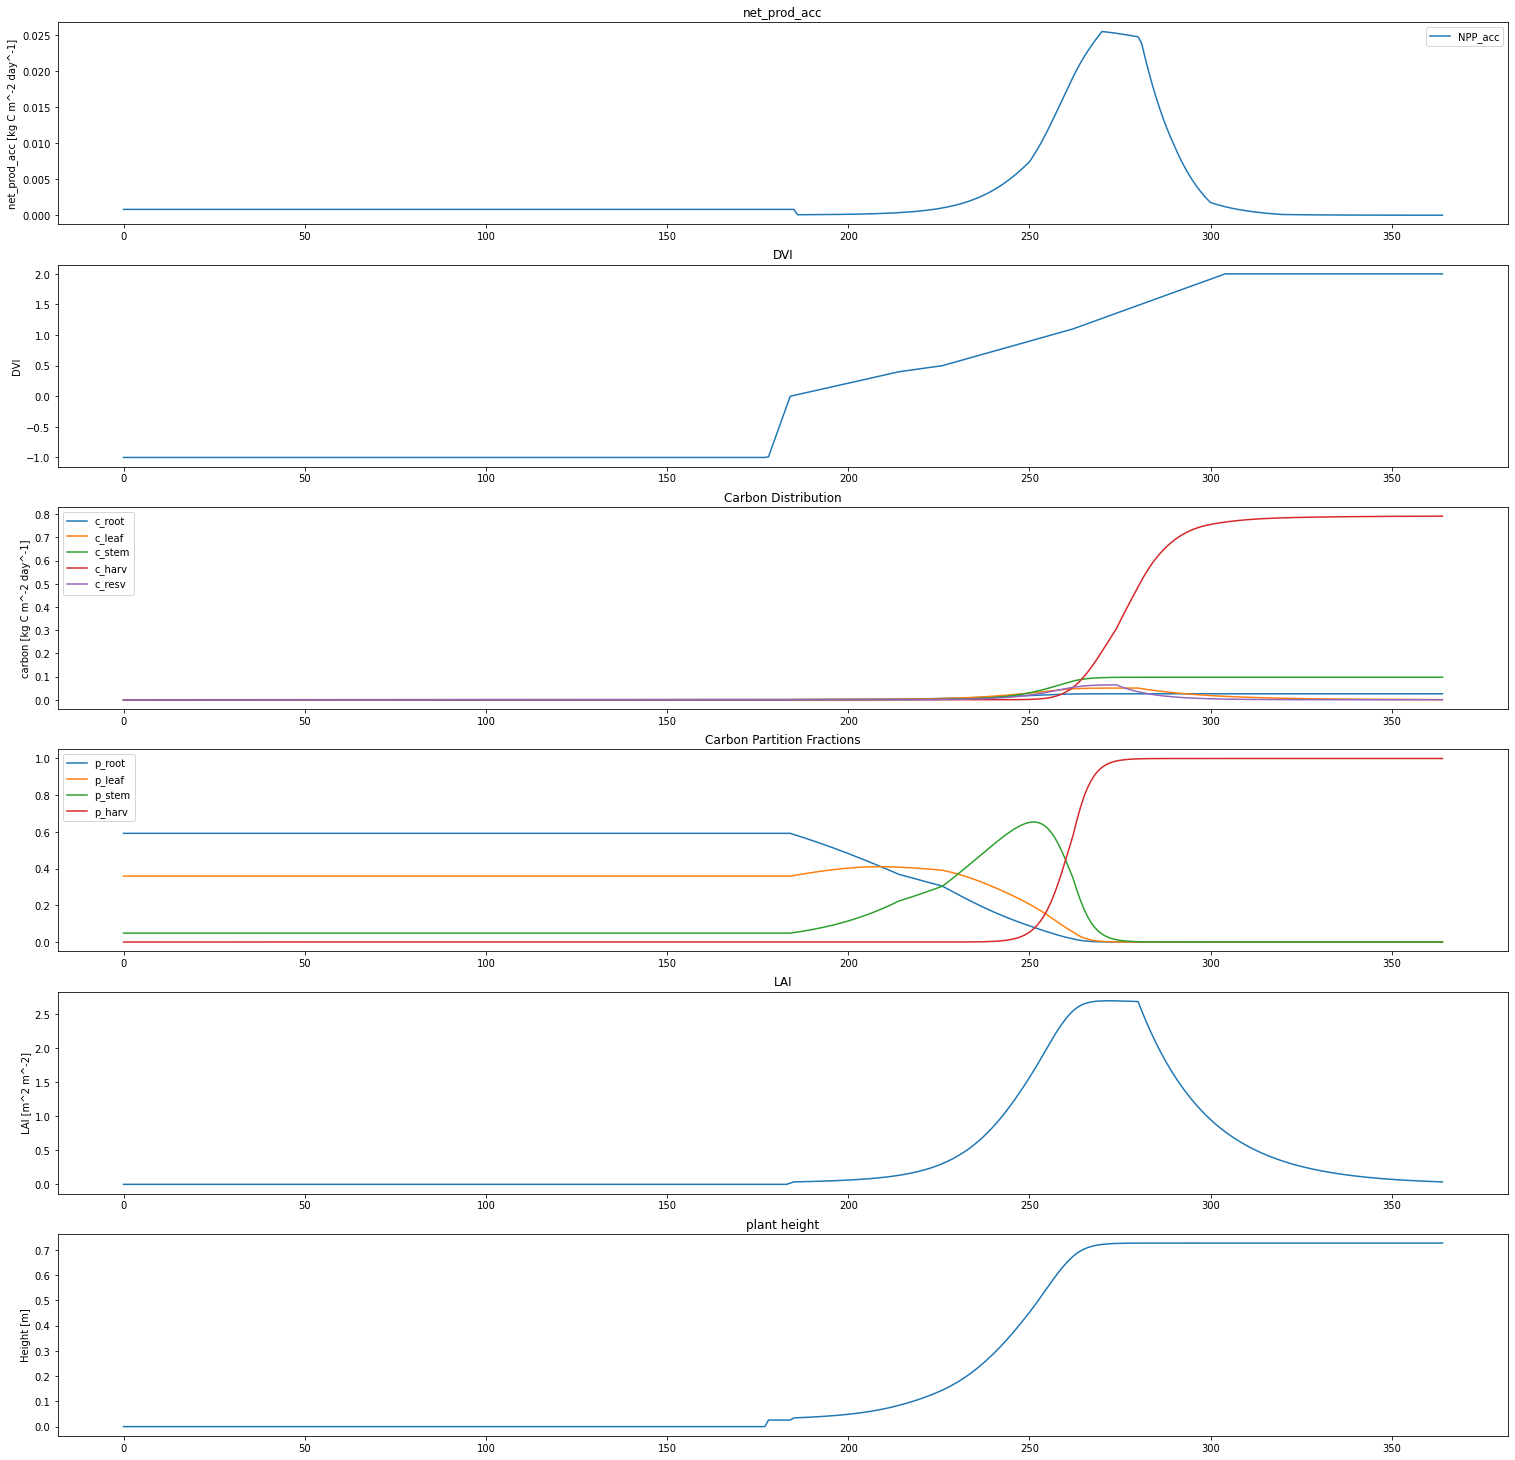

In [288]:
def draw_plots(output_logs):
    fig, axs = plt.subplots(ncols=1, nrows=6, figsize=(26,26))

    # Draw net_prod
    axs[0].plot(list(map(lambda o: o.net_prod_acc, output_logs)), label="NPP_acc")
    # axs[0].plot(dd_hourly, np.array(anet_hourly) / 1, label="anet 1e2")
    axs[0].set_title("net_prod_acc")
    axs[0].legend()
    axs[0].set_ylabel("net_prod_acc [kg C m^-2 day^-1]")
    
    # DVI
    axs[1].plot(dd_hourly, dvi_hourly)
    axs[1].set_title("DVI")
    axs[1].set_ylabel("DVI")

    # Carbon Pools
    axs[2].plot(list(map(lambda o: o.c_root, output_logs)), label="c_root")
    axs[2].plot(list(map(lambda o: o.c_leaf, output_logs)), label="c_leaf")
    axs[2].plot(list(map(lambda o: o.c_stem, output_logs)), label="c_stem")
    axs[2].plot(list(map(lambda o: o.c_harv, output_logs)), label="c_harv")
    axs[2].plot(list(map(lambda o: o.c_resv, output_logs)), label="c_resv")
    axs[2].set_ylabel("carbon [kg C m^-2 day^-1]")
    axs[2].set_title("Carbon Distribution")
    axs[2].legend()

    # Carbon Partitions
    axs[3].plot(list(map(lambda o: o.p_root, output_logs)), label="p_root")
    axs[3].plot(list(map(lambda o: o.p_leaf, output_logs)), label="p_leaf")
    axs[3].plot(list(map(lambda o: o.p_stem, output_logs)), label="p_stem")
    axs[3].plot(list(map(lambda o: o.p_harv, output_logs)), label="p_harv")
    axs[3].set_title("Carbon Partition Fractions")
    axs[3].legend()

    # LAI
    axs[4].plot(list(map(lambda o: o.lai, logs)), label="lai")
    axs[4].set_ylabel("LAI [m^2 m^-2]")
    axs[4].set_title("LAI")

    # Height
    axs[5].plot(list(map(lambda o: o.plant_height, logs)), label="plant_height")
    axs[5].set_ylabel("Height [m]")
    axs[5].set_title("plant height")
draw_plots(logs)

---

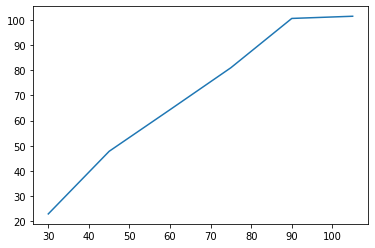

In [214]:
# Expected plant height
x = [30,45,60,75,90,105]
y = [22.95, 47.81, 64.34, 81.00, 100.56, 101.43]
plt.plot(x, y)

# Initial conditions

In [215]:
# DVI = 0
DVI=0
net_prod_acc = init_carbon

(p_root, p_leaf, p_stem, p_harv) = calc_partition_coefficients(
    DVI,  # -1 -> 2
    cparams["a_root"],
    cparams["a_leaf"],
    cparams["a_stem"],
    cparams["b_root"],
    cparams["b_leaf"],
    cparams["b_stem"],
)

(
    c_root_diff,
    c_leaf_diff,
    c_stem_diff,
    c_harv_diff,
    c_resv_diff
) = calc_carbon_pool_change(
    net_prod_acc,  # acumulated net productivity
    p_root,  # partition coefficient for root
    p_leaf,  # partition coefficient for leaf
    p_stem,  # partition coefficient for stem
    p_harv,  # partition coefficient for harv
    cparams["pr_resv"],
)

if DVI > 0:
    assert False
    c_root = max(0, model_state.c_root + c_root_diff)
    c_stem = max(0, model_state.c_stem + c_stem_diff)
    c_leaf = max(0, model_state.c_leaf + c_leaf_diff)
    c_harv = max(0, model_state.c_harv + c_harv_diff)
    c_resv = max(0, model_state.c_resv + c_resv_diff)
elif DVI > -1:
    c_root = c_root_diff
    c_stem = c_leaf_diff
    c_leaf = c_stem_diff
    c_harv = c_harv_diff
    c_resv = c_resv_diff
else:
    assert False
    c_root = 0
    c_stem = 0
    c_leaf = 0
    c_harv = 0
    c_resv = 0

lai = calc_LAI_from_DVI_and_carbon(
    DVI,
    c_leaf,
    gamma=cparams["gamma"],  # Param
    delta=cparams["delta"],  # Param
    f_c=0.5,  # Const
)

plant_height = get_plant_height_from_carbon(
    c_stem,
    lambdav=0.4,  # Param same for all cultivars in table 4
    k=cparams["k"],  # Param
    f_c=0.5,  # Const
)

In [216]:
lai, plant_height


(0.018366423974397857, 0.1943877136756202)

In [217]:
c_root, c_stem, c_leaf, c_harv, c_resv
# 0.000563611	0.000224927	6.88E-06	1.96E-14	4.58E-06
# 

(0.005922010669465662,
 0.003591881038176261,
 0.00029166494259228164,
 5.470427545684183e-11,
 0.0001944432950615211)

In [218]:
dd = 184
net_prod_acc = 0
hourly_net_prod = []
for hr in range(24):
    row_index = (dd * 24) + hr
    DVI = dvi_hourly[row_index]
    An_canopy = anet_hourly[row_index]
    net_prod = calc_net_prod(
        An_canopy,
        c_root,
        c_stem,
        c_leaf,
        0,#umol_c_to_kg_c(cparams["R_dc"]),
        cparams["r_g"],
    )
    net_prod_acc +=net_prod
    hourly_net_prod.append(net_prod)

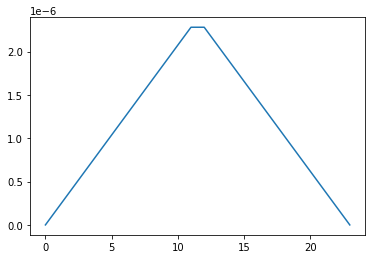

In [219]:
plt.plot(hourly_net_prod)

To get a total annual accumulated NPP we need to get an average hourlt Ac value of...

In [242]:
# To get a total annual accumulated NPP we need to get an average hourlt Ac value of...
annual_NPP_acc = 1.0 # kg..
average_hourly_NPP = annual_NPP_acc / (365*24)
print(f"average_hourly_NPP: {average_hourly_NPP}")
average_hourly_Ac = average_hourly_NPP/(0.012*0.75)
annual_Ac_acc = average_hourly_Ac * (365*24)
print(f"average_hourly_Ac:{average_hourly_Ac}, \nannual_Ac_acc: {annual_Ac_acc}")

average_hourly_NPP: 0.00011415525114155251
average_hourly_Ac:0.012683916793505832, 
annual_Ac_acc: 111.11111111111109


In [237]:
average_hourly_Ac = average_hourly_NPP/(0.012*0.75)
annual_Ac_acc = average_hourly_Ac * (365*24)
average_hourly_Ac, annual_Ac_acc


(0.012683916793505832, 111.11111111111109)

In [258]:
umol_c_to_kg_c(40)

0.0017279999999999997